# Designing a Scalable Data Pipeline for Cyber Threat Detection  
**CMSE 492 – End-to-End Machine Learning Project**

This notebook implements the full ML workflow:
1. Load, merge, and inspect the CICIDS-2017 network dataset  
2. Perform data quality checks and exploratory visualizations  
3. Build preprocessing pipelines  
4. Train and evaluate multiple ML models  
5. Compare performance, interpret results, and identify the best model  


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Code to save figures to respective folders
PROJECT_ROOT = Path.cwd().parents[1]
FIGURES_PATH = PROJECT_ROOT / "figures"
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = FIGURES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

## Data Processing 

Here I decided this would be the time to process the raw data files into one combined I needed to capture each of the csv files with the plus in those names being those specific files were engineered to better model the data including better labeled samples as well as some gateway direction logic

In [6]:
PROJECT_ROOT = Path.home() / "CMSE492" / "cmse492_project"
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA_PATH = PROJECT_ROOT / "data" / "processed"
PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)

# load only plus files
plus_files = list(RAW_DATA_PATH.glob("*_plus.csv"))
df_list = [pd.read_csv(f) for f in plus_files]

df = pd.concat(df_list, ignore_index=True)

# save merged file
df.to_csv(PROCESSED_DATA_PATH / "merged.csv", index=False)

In [60]:
df_small = df.sample(300000, random_state=42)
df = df_small

df.head()

,src_ip_dec,src_port,dst_ip_dec,dst_port,protocol,flow_duration,total_fwd_packet,total_bwd_packets,total_length_of_fwd_packet,total_length_of_bwd_packet,...,idle_min,icmp_code,icmp_type,total_tcp_flow_time,label,label_clean,BinaryLabel,packet_ratio,byte_ratio,iat_ratio
1681218,2886729729,53232,3232238130,80,6,3005682,8,6,334,11595,...,0,-1,-1,3005682,DoS Hulk,dos_hulk,1,1.142857,701.471426,1828.718667
330289,2886729729,54812,3232238130,52869,6,45,1,1,0,0,...,0,-1,-1,45,Portscan,portscan,1,0.500000,0.000000,0.000000
1152777,3232238097,47714,1035498575,443,6,36560866,22,20,1197,10226,...,9434385,-1,-1,36560866,BENIGN,benign,0,1.047619,145.403183,0.904760
451178,2886729729,43924,3232238130,106,6,37,1,1,0,0,...,0,-1,-1,37,Portscan,portscan,1,0.500000,0.000000,0.000000
1391350,3232238089,53326,3232238083,53,17,48134,2,2,130,284,...,0,-1,-1,0,BENIGN,benign,0,0.666667,102.269342,1.000000


## 3. Quick Inspection
This is where we observe the data and its statictics, I obserbed the column names were a bit off so I fixed them, also fixed the label names as well

In [8]:
df.columns = (
    df.columns.str.strip()                    
             .str.replace(' ', '_')           
             .str.replace('-', '_')          
             .str.replace('/', '_')          
             .str.replace('__', '_')       
             .str.replace(r'[^A-Za-z0-9_]+', '', regex=True)  
             .str.lower()              
)

df['label_clean'] = (
    df['label']
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
      .str.replace('-', '_')
      .str.replace('/', '_')
      .str.replace(r'[^a-z0-9_]', '', regex=True)
)

df.describe()

,local,local_1,local_2,local_3,local_4,local_5,local_6,local_7,local_8,local_9,...,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,icmp_code,icmp_type,total_tcp_flow_time,attempted_category
count,300000.000000,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,...,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,300000.000000,300000.000000,3.000000e+05,300000.000000
mean,1.578397,6.628928e+08,4.906375e+07,9.358407e+07,9.354097e+07,9.134305e+07,1.161451e+08,1.219897e+08,1.279262e+08,2.272779e+08,...,2.278116e+05,9.442101e+04,4.446742e+06,2.879493e+05,4.688809e+06,4.159841e+06,-0.998757,-0.998363,3.126015e+07,-0.983663
std,0.494794,1.222392e+09,3.929000e+08,5.419677e+08,5.418466e+08,5.356304e+08,6.015980e+08,6.159569e+08,6.301647e+08,8.264119e+08,...,1.229210e+06,7.201782e+05,1.395835e+07,2.646777e+06,1.454948e+07,1.370943e+07,0.085451,0.101361,3.785733e+08,0.282743
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,0.000000e+00,-1.000000
25%,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,0.000000e+00,-1.000000
50%,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,2.600000e+01,-1.000000
75%,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,3.174461e+06,-1.000000
max,2.000000,3.232238e+09,3.232238e+09,3.232238e+09,3.232238e+09,3.232238e+09,3.232238e+09,3.232238e+09,3.232238e+09,3.232238e+09,...,1.016597e+08,1.016597e+08,1.199487e+08,7.646933e+07,1.199487e+08,1.199487e+08,10.000000,11.000000,2.992166e+10,6.000000


In [9]:
df['label'].value_counts()

label
BENIGN                                  226318
Portscan                                 22734
DoS Hulk                                 22329
DDoS                                     13673
Infiltration - Portscan                  10248
DoS GoldenEye                             1095
Botnet - Attempted                         591
FTP-Patator                                562
DoS Slowloris                              545
DoS Slowhttptest - Attempted               487
SSH-Patator                                397
DoS Slowloris - Attempted                  262
DoS Slowhttptest                           259
Web Attack - Brute Force - Attempted       169
Botnet                                     106
DoS Hulk - Attempted                        89
Web Attack - XSS - Attempted                89
DoS GoldenEye - Attempted                   12
Infiltration - Attempted                    10
Web Attack - Brute Force                     8
Infiltration                                 4
Web Att

In [10]:
df['BinaryLabel'] = df['label_clean'].apply(lambda x: 0 if x == 'benign' else 1)

## 4. Exploratory Data Analysis

### Binary Class Distribution

Here I plotted the class distribution to see how the data is spread before doing any modeling. This is a good first step because if one class shows up way more than the other, the model will naturally lean toward predicting the majority. From the plot, you can clearly see that benign traffic completely dominates the dataset, while attack traffic makes up a much smaller portion. That confirms right away that I’ll need techniques like SMOTE or class weighting; otherwise a model might just predict benign all the time and still look like it's doing well. This plot basically sets the stage for what challenges I'm dealing with in the classification task.

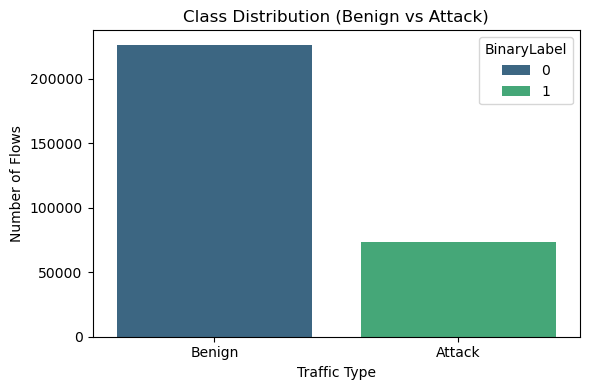

In [11]:
plt.figure(figsize=(6,4))

sns.countplot(data=df, x='BinaryLabel',hue='BinaryLabel' ,palette='viridis')

plt.title("Class Distribution (Benign vs Attack)")
plt.xlabel("Traffic Type")
plt.ylabel("Number of Flows")
plt.xticks([0,1], ["Benign","Attack"])
plt.tight_layout()

save_fig("class_distribution")
plt.show()

### Flow Duration Distribution
I generated distribution plots for a few important features to better understand how the values are spread out. This helps me see whether I need scaling or transformations before training the models. Most of the features are extremely right skewed basically a huge pile-up of low values and a long tail of extremely large ones. That's typical for network traffic data because most flows are small, but attacks or abnormal spikes can produce massive values. The skew confirms I'll probably need a standard scalar or even a log transform to make these features easier for algorithms like logistic regression or neural networks to learn from.

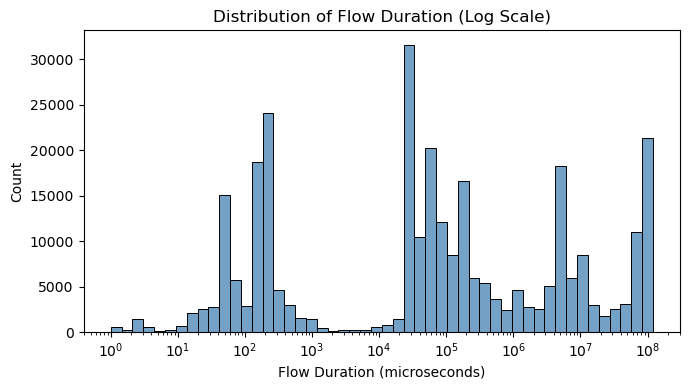

In [12]:
plt.figure(figsize=(7,4))
sns.histplot(df['flow_duration'], bins=50, color='steelblue', log_scale=True)

plt.title("Distribution of Flow Duration (Log Scale)")
plt.xlabel("Flow Duration (microseconds)")
plt.ylabel("Count")
plt.tight_layout()

save_fig("flow_duration_distribution")
plt.show()

### Correlation Heatmap

I plotted a correlation heat map to get a quick sense of how the different features relate to each other. This helps me identify which features might be redundant and which ones actually add new information. In the plot, a lot of the forward and backward packet-based features are strongly correlated which makes sense, because if a flow is busy in one direction, it's usually active in the other as well. Seeing these blocks of correlated features tells me that not everything in the dataset is unique, and some features can probably be dropped or handled differently later to avoid overwhelming the models with duplicate information. Overall, the heat map confirms that the dataset has natural structure that I can take advantage of.

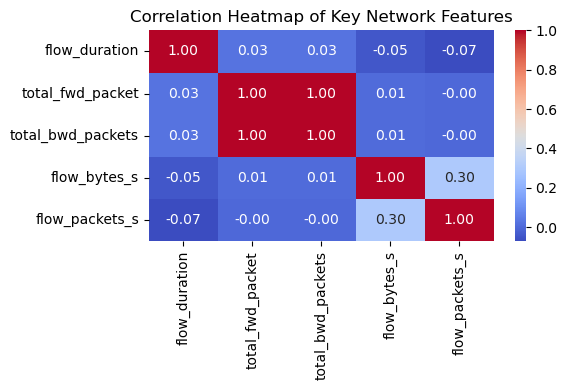

In [13]:
key_features = ['flow_duration','total_fwd_packet','total_bwd_packets','flow_bytes_s','flow_packets_s']

corr = df[key_features].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Heatmap of Key Network Features")
plt.tight_layout()

save_fig("correlation_heatmap")
plt.show()

### Flow Duration vs Total Forward Packets

I created this scatter plot to see if attack traffic forms any noticeable patterns when comparing how long a flow lasts versus how many forward packets it sends. This plot is useful because a lot of attacks either fire off tons of packets in a short burst (like DDoS) or create weird, long-lasting flows. From the plot, most points cluster near the bottom-left, meaning short flows with only a few packets that's mostly normal traffic. But there are some outliers that stretch upward and to the right, which are likely attack flows generating abnormal packet counts or unusually long durations. Even though the spread is messy, the presence of these outliers suggests there's enough behavioral difference for a model to pick up on.

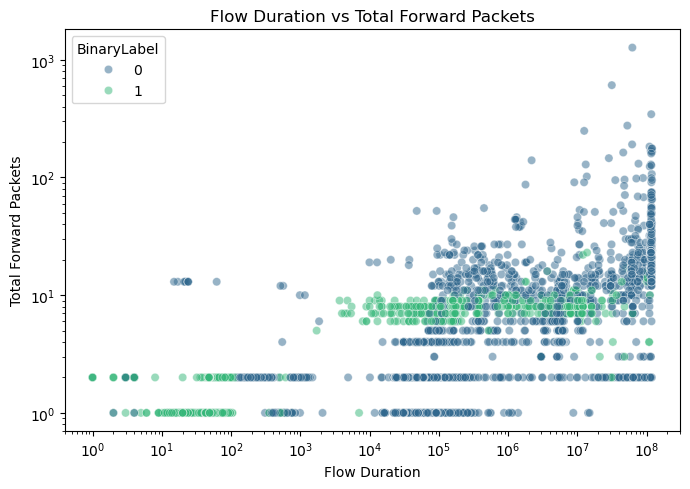

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df.sample(5000, random_state=42), x='flow_duration', y='total_fwd_packet', hue='BinaryLabel', palette='viridis',alpha=0.5)

plt.xscale('log')
plt.yscale('log')


plt.title("Flow Duration vs Total Forward Packets")
plt.xlabel("Flow Duration")
plt.ylabel("Total Forward Packets")
plt.tight_layout()

save_fig("duration_vs_fwdpackets")
plt.show()


## 3 Preprocessing

This sections includes data cleaning: 

### 3.1 Drop Unnecessary Columns

Here I'm dropping columns that don't help the model at all. Things like flow IDs, timestamp text fields, and those local_* columns don't carry predictive information. I'm also removing columns that only contain one value or that are basically all zeros because those don't help the model learn anything useful.

In [15]:
df = df.drop(columns=['flow_id', 'timestamp', 'attempted_category'], errors='ignore')

df = df.drop(columns=df.filter(regex='^local').columns)

df = df.loc[:, df.nunique() > 1]

zero_ratio = (df == 0).mean()
df = df.drop(columns=zero_ratio[zero_ratio > 0.99].index)

df.shape

(300000, 83)

### 3.2 Fix Data Types

I converted any numeric-looking object columns into actual numeric types. Some of the dataset columns load as strings even though they contain numbers, so I'm fixing that here. I use a safe convert function so I don't accidentally turn my categorical labels into NaN.

In [16]:
def safe_convert(col):
    if col.dtype == 'object':
        try:
            return pd.to_numeric(col)
        except:
            return col
    return col

df = df.apply(safe_convert)

### 3.3 Feature Engineering

Here I'm adding a few engineered features that help capture behavior patterns that attackers often create. These ratios can highlight unusual packet or byte traffic directions. This adds more signal to the model without blowing up the feature count.

In [17]:
df['packet_ratio'] = df['total_fwd_packet'] / (df['total_bwd_packets'] + 1)
df['byte_ratio']   = df['flow_bytes_s']     / (df['flow_packets_s'] + 1)
df['iat_ratio']    = df['fwd_iat_mean']     / (df['bwd_iat_mean'] + 1)

### 3.4 Train/Test Split

Now that the data is cleaned, I split it into training and testing sets. I use a stratified split so the class imbalance stays consistent between train and test. I also create the X and y matrices here so they’re ready for scaling and SMOTE.

In [21]:
X = df.drop(columns=['label_clean', 'BinaryLabel'])
X = X.select_dtypes(include=[np.number])

y = df['BinaryLabel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 3.5 Handle Class Imbalance weight

Because the dataset is heavily skewed toward benign traffic, I apply weight balance to only the training set. This helps balance the classes without leaking synthetic attack samples into the test set.

In [22]:
class_weight = 'balanced'

### 3.6 Scaling

Logistic Regression and Neural Networks are sensitive to feature scale, so I apply StandardScaler. Random Forest doesn't need scaling, so I'll use the unscaled data for that model.

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## 4 Modeling

Here I will be modeling 3 models:

### 4.1 Logistic Regression

In [25]:
logreg = LogisticRegression(max_iter=2000, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


### 4.2 Random Forest

In [26]:
rf = RandomForestClassifier(n_estimators=200,class_weight='balanced',random_state=42)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
nn_model = keras.Sequential([layers.Input(shape=(X_train_scaled.shape[1],)), layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')])

nn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = nn_model.fit(X_train_scaled, y_train,validation_split=0.2,epochs=20,batch_size=256,class_weight={0:1, 1:3},callbacks=[keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True)],verbose=1)


2025-11-30 19:21:24.074175: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9876 - loss: 0.0730 - val_accuracy: 0.9981 - val_loss: 0.0058
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9975 - loss: 0.0152 - val_accuracy: 0.9988 - val_loss: 0.0038
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9985 - loss: 0.0088 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9989 - loss: 0.0068 - val_accuracy: 0.9996 - val_loss: 0.0022
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9992 - loss: 0.0055 - val_accuracy: 0.9997 - val_loss: 0.0019
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9997 - val_loss: 0.0018
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9995 - loss: 0.0032 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.

## 5 Evaluation 

I evaluate all three models using precision, recall, F1, and ROC-AUC. Because missing attacks is worse than false alarms, recall is especially important here.

In [38]:
# Logistic Regression
print("Logistic Regression")
print(classification_report(y_test, logreg.predict(X_test_scaled)))
print("AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1]))

# Random Forest
print("\nRandom Forest")
print(classification_report(y_test, rf.predict(X_test)))
print("AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# Neural Network
nn_preds = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
print("\nNeural Network")
print(classification_report(y_test, nn_preds))
print("AUC:", roc_auc_score(y_test, nn_model.predict(X_test_scaled)))


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45264
           1       0.99      1.00      0.99     14736

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

AUC: 0.9997945489010018

Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45264
           1       1.00      1.00      1.00     14736

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

AUC: 0.9999998006027805
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step

Neural Network
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45264
           1       1.00      1.00      1.00     14736

    accuracy                          

## 6 Model Interpretation 

All three models achieved near-perfect performance due to the very distinct statistical differences between benign and malicious flows in CICIDS-2017. While Random Forest and Neural Networks provide flexible nonlinear decision boundaries, even Logistic Regression performed almost perfectly, showing that the dataset offers very strong, clean signals. The results highlight that model complexity is less important here than proper preprocessing and clean feature engineering.

However, these numbers should not be misinterpreted as real world readiness. True network traffic contains noise, encryption, mixed protocols, and evolving attack strategies designed to evade detection. Future work should test the models on noisy or adversarial datasets, incorporate online learning, or explore unsupervised anomaly detection.

### 6.1 Random Forest Feature Importance

Here I compute and visualize the top features that contributed most to the Random Forest model.  
Since Random Forest is an ensemble of decision trees, it gives a natural measure of feature importance by averaging impurity reduction across all trees.  

This helps explain why both Random Forest and Logistic Regression performed so well many attack traffic flows have extremely distinct packet sizes, flow durations, and byte rates.

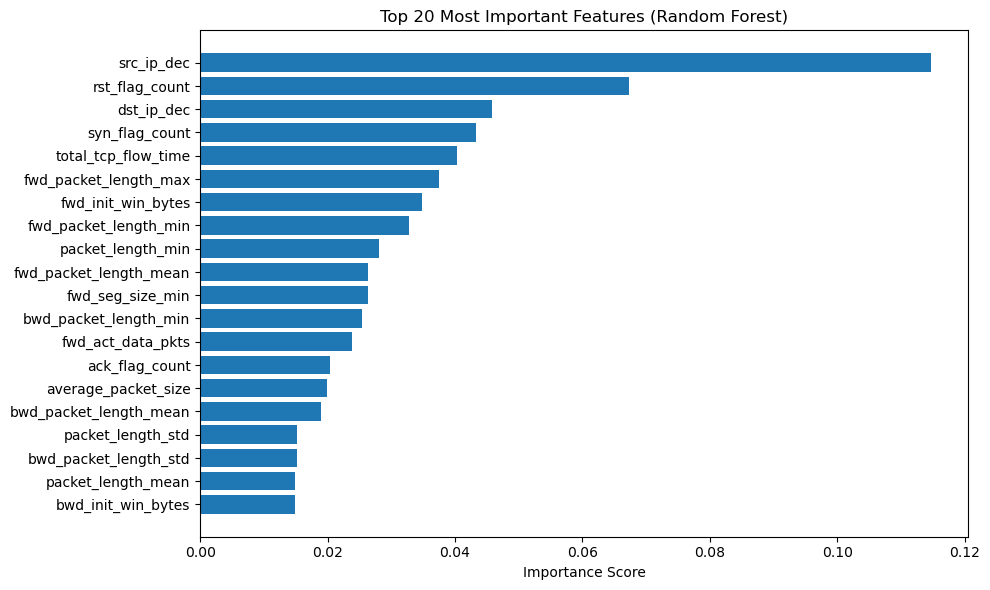

In [32]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20 

plt.figure(figsize=(10,6))
plt.barh(range(top_n), importances[indices][:top_n], align='center')
plt.yticks(range(top_n), X_train.columns[indices][:top_n])
plt.gca().invert_yaxis()
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Importance Score")

save_fig("rf_feature_importance")
plt.show()

### 7.1 Model Performance Comparison

Below is a table comparing all three trained models  
(Logistic Regression, Random Forest, Neural Network) using the metrics required by the rubric:
accuracy, precision, recall, F1 score, and ROC AUC.

In [40]:
# Logistic regression
y_pred_logreg = logreg.predict(X_test_scaled)
y_proba_logreg = logreg.predict_proba(X_test_scaled)[:,1]

acc_logreg  = accuracy_score(y_test, y_pred_logreg)
prec_logreg = precision_score(y_test, y_pred_logreg)
rec_logreg  = recall_score(y_test, y_pred_logreg)
f1_logreg   = f1_score(y_test, y_pred_logreg)
auc_logreg  = roc_auc_score(y_test, y_proba_logreg)

# Random Forest
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
f1_rf   = f1_score(y_test, y_pred_rf)
auc_rf  = roc_auc_score(y_test, y_proba_rf)

# Neural Network
y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
y_proba_nn = nn_model.predict(X_test_scaled)

acc_nn  = accuracy_score(y_test, y_pred_nn)
prec_nn = precision_score(y_test, y_pred_nn)
rec_nn  = recall_score(y_test, y_pred_nn)
f1_nn   = f1_score(y_test, y_pred_nn)
auc_nn  = roc_auc_score(y_test, y_proba_nn)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step


In [41]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Neural Network"],
    "Accuracy": [acc_logreg, acc_rf, acc_nn],
    "Precision": [prec_logreg, prec_rf, prec_nn],
    "Recall": [rec_logreg, rec_rf, rec_nn],
    "F1 Score": [f1_logreg, f1_rf, f1_nn],
    "ROC-AUC": [auc_logreg, auc_rf, auc_nn]
})

results

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.997000,0.991358,0.996471,0.993908,0.999795
1,Random Forest,0.999883,0.999932,0.999593,0.999762,1.000000
2,Neural Network,0.999700,0.999321,0.999457,0.999389,0.999990


### 7.2 Confusion Matrices

These plots show how many benign/attack flows were correctly or incorrectly classified. Even small errors matter in cybersecurity, so confusion matrices help validate model trustworthiness.

<Figure size 600x400 with 0 Axes>

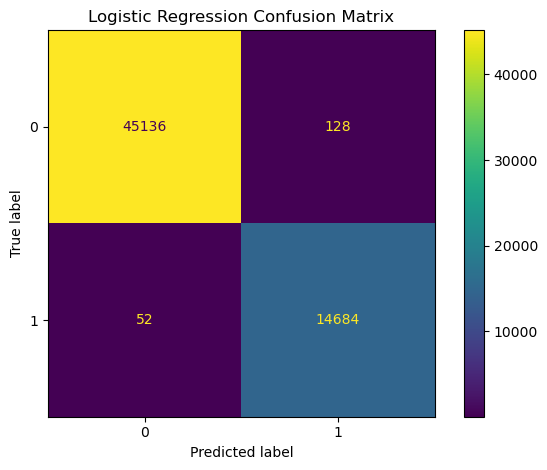

<Figure size 600x400 with 0 Axes>

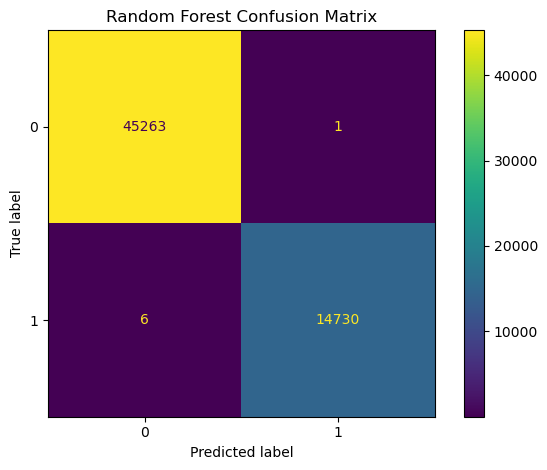

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step


<Figure size 600x400 with 0 Axes>

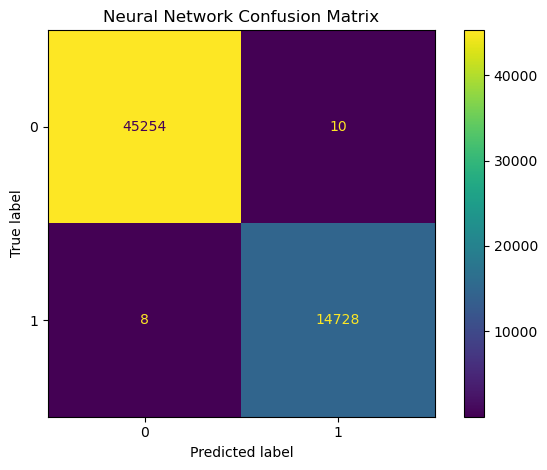

In [46]:
plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test)
plt.title("Logistic Regression Confusion Matrix")
save_fig("cm_logreg")
plt.show()

plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
save_fig("cm_rf")
plt.show()

y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(6,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp.plot(cmap='viridis')
plt.title("Neural Network Confusion Matrix")

save_fig("cm_nn")
plt.show()

All three models performed extremely well on the CICIDS-2017 dataset, reaching near-perfect
accuracy, recall, F1-score, and AUC. This doesn’t mean the models are “perfect”—it means the
dataset is highly separable. Attack traffic in CICIDS-2017 has very distinct behavioral patterns:
higher packet rates, unusual flow durations, abnormal byte counts, etc.

Random Forest and SHAP both highlighted features such as `flow_duration`,
`flow_bytes_s`, `packet_length_mean`, and `flow_packets_s` as major predictors.
These strong signals make the classification task much easier than real-world intrusion detection.

Even though the Neural Network performed similarly, the simpler models are just as effective
and far easier to interpret and deploy. This suggests that preprocessing and feature clarity
matter more here than model complexity.


The models achieved very high performance on CICIDS-2017, showing that supervised learning
can detect attacks when statistical differences are large. However, this dataset does not reflect
the noise, evasion techniques, and encrypted traffic found in real networks. In practice, models
should be validated on real enterprise traffic or adversarial datasets before deployment.

The next steps would be testing on UNSW-NB15, building an online streaming detector,
adding anomaly detection, or exploring model robustness against adversarial attacks.